# ML test
### Testing of reading in data and trying an auto encoder
Remember to pip3 install keras-tuner to tune for the given session

In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import tensorflow as tf
import keras_tuner as kt
seed = tf.random.set_seed(1)
#import ROOT as R

In [193]:
df = pd.read_hdf("/storage/shared/data/2lep_df_forML.hdf5")
df = pd.concat([df,pd.read_hdf("/storage/shared/data/2lep_df_forML_signal.hdf5")])



In [194]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 109683372 entries, 0 to 2785053
Data columns (total 21 columns):
 #   Column    Dtype  
---  ------    -----  
 0   lep_pt1   float64
 1   lep_eta1  float64
 2   lep_phi1  float64
 3   lep_E1    float64
 4   lep_pt2   float64
 5   lep_eta2  float64
 6   lep_phi2  float64
 7   lep_E2    float64
 8   met       float64
 9   mll       float64
 10  njet20    int64  
 11  njet60    int64  
 12  nbjet60   int64  
 13  nbjet70   int64  
 14  nbjet77   int64  
 15  nbjet80   int64  
 16  isSF      int64  
 17  isOS      int64  
 18  weight    float64
 19  category  object 
 20  isSignal  int64  
dtypes: float64(11), int64(9), object(1)
memory usage: 18.0+ GB


In [195]:
categories = df["category"]

background_categories = df[df["isSignal"] == 0]["category"].unique()
signal_df = df[df['category'] == 'SUSYC1C1']

background_df = df[df["isSignal"] == 0]

columns_to_drop = ["category", "isSignal"]


signal_df.drop(columns_to_drop, axis=1, inplace=True)
background_df.drop(columns_to_drop, axis=1, inplace=True)

signal_mc = signal_df#.to_numpy()
background_mc = background_df#.to_numpy()


/storage/software/easybuild/software/SciPy-bundle/2020.11-fosscuda-2020b/lib/python3.8/site-packages/pandas/core/frame.py:4167: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [196]:
print(np.shape(background_mc))
print(np.shape(signal_mc))

(106898318, 19)
(135127, 19)


### Data handling and preperations
Before we train on the data, we need to scale it and split it into a validation and 

In [197]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

In [198]:
# Split background
X_b_train, X_b_val = train_test_split(background_mc, test_size=0.2, random_state=seed)
# Split signal
#X_s_train, X_s_test = train_test_split(signal_mc, test_size=0.2, random_state=seed)

Now, combine samples for testing

In [199]:
b_train_weights = X_b_train["weight"]
b_val_weights = X_b_val["weight"]
s_test_weights = signal_mc["weight"]


X_b_train.pop("weight")
X_b_val.pop("weight")
signal_mc.pop("weight")


X_s_test = signal_mc


X_test = np.concatenate((X_b_val,X_s_test),0)

y_b_val = np.zeros(X_b_val.shape[0])                                                                                                                                                                                                                                                   
y_s_test = np.ones(X_s_test.shape[0])      
y_test = np.concatenate((y_b_val,y_s_test),0)

In [200]:
X_b_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 85518654 entries, 42061528 to 14927437
Data columns (total 18 columns):
 #   Column    Dtype  
---  ------    -----  
 0   lep_pt1   float64
 1   lep_eta1  float64
 2   lep_phi1  float64
 3   lep_E1    float64
 4   lep_pt2   float64
 5   lep_eta2  float64
 6   lep_phi2  float64
 7   lep_E2    float64
 8   met       float64
 9   mll       float64
 10  njet20    int64  
 11  njet60    int64  
 12  nbjet60   int64  
 13  nbjet70   int64  
 14  nbjet77   int64  
 15  nbjet80   int64  
 16  isSF      int64  
 17  isOS      int64  
dtypes: float64(10), int64(8)
memory usage: 12.1 GB


In [201]:
scaler_ae = StandardScaler()#MinMaxScaler()
X_b_train = scaler_ae.fit_transform(X_b_train)                                                                                                                                                                                                                        
X_b_val= scaler_ae.transform(X_b_val)                                                                                                                                                                                                                                 
X_s_test = scaler_ae.transform(X_s_test)

In [202]:
data_shape = np.shape(X_b_train)[1]
number_of_rows = np.shape(X_b_train)[0]
n_vali = np.shape(X_b_val)[0]

random_indices_b = np.random.choice(number_of_rows, size=int(1e6), replace=False)
test_indices_b = np.random.choice(n_vali, size=int(200000), replace=False)

smaller_data = X_b_train[random_indices_b, :]
small_vali = X_b_val[test_indices_b, :]


test_indices_sb = np.random.choice(np.shape(X_test)[0], size=int(200000), replace=False)
X_small_test = X_test[test_indices_sb, :]

### Training
Now we can train on the data

In [35]:

def gridautoencoder(X_b, X_back_test):
    tuner = kt.Hyperband(
        AE_model_builder,
        objective=kt.Objective("val_mse", direction="min"),
        max_epochs=50,
        factor=3,
        directory="GridSearches",
        project_name="AE",
        overwrite=True,
    )

    tuner.search(X_b, X_b, epochs=50, batch_size=4000,
                 validation_data=(X_back_test, X_back_test))
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

    print(
        f"""
    For Encoder: \n 
    First layer has {best_hps.get('num_of_neurons0')} with activation {best_hps.get('0_act')} \n
    Second layer has {best_hps.get('num_of_neurons1')} with activation {best_hps.get('1_act')} \n
    
    Latent layer has {best_hps.get("lat_num")} with activation {best_hps.get('2_act')} \n
    \n
    For Decoder: \n 
    First layer has {best_hps.get('num_of_neurons5')} with activation {best_hps.get('5_act')}\n
    Second layer has {best_hps.get('num_of_neurons6')} with activation {best_hps.get('6_act')}\n
    Third layer has activation {best_hps.get('7_act')}\n
    \n
    with learning rate = {best_hps.get('learning_rate')} and alpha = {best_hps.get('alpha')}
    """
    )

    state = True
    while state == True:
        answ = input("Do you want to save model? (y/n) ")
        if answ == "y":
            name = input("name: ")
            tuner.hypermodel.build(best_hps).save(
                f"../tf_models/model_{name}.h5")
            state = False
            print("Model saved")
        elif answ == "n":
            state = False
            print("Model not saved")


def AE_model_builder(hp):
    

    alpha_choice = hp.Choice("alpha", values=[1., 0.5, 0.1, 0.05, 0.01])
    #get_custom_objects().update({"leakyrelu": tf.keras.layers.LeakyReLU(alpha=alpha_choice)})
    activations = {
        "relu": tf.nn.relu,
        "tanh": tf.nn.tanh,
        "leakyrelu": lambda x: tf.nn.leaky_relu(x, alpha=alpha_choice),
        "linear": tf.keras.activations.linear
    }
    inputs = tf.keras.layers.Input(shape=data_shape, name="encoder_input")
    x = tf.keras.layers.Dense(
        units=hp.Int("num_of_neurons0", min_value=13, max_value=17, step=1),
        activation=activations.get(hp.Choice(
            "0_act", ["relu", "tanh", "leakyrelu"])))(inputs)
    x1 = tf.keras.layers.Dense(
        units=hp.Int("num_of_neurons1", min_value=7, max_value=12, step=1),
        activation=activations.get(hp.Choice(
            "1_act", ["relu", "tanh", "leakyrelu","linear"]))
    )(x)
    val = hp.Int("lat_num", min_value=1, max_value=6, step=1)
    x2 = tf.keras.layers.Dense(
        units=val, activation=activations.get(hp.Choice(
            "2_act", ["relu", "tanh", "leakyrelu","linear"]))
    )(x1)
    encoder = tf.keras.Model(inputs, x2, name="encoder")

    latent_input = tf.keras.layers.Input(shape=val, name="decoder_input")
    x = tf.keras.layers.Dense(
        units=hp.Int("num_of_neurons5", min_value=7, max_value=12, step=1),
        activation=activations.get(hp.Choice(
            "5_act", ["relu", "tanh", "leakyrelu","linear"]))
    )(latent_input)
    x1 = tf.keras.layers.Dense(
        units=hp.Int("num_of_neurons6", min_value=13, max_value=17, step=1),
        activation=activations.get(hp.Choice(
            "6_act", ["relu", "tanh", "leakyrelu","linear"]))
    )(x)
    output = tf.keras.layers.Dense(
        data_shape, activation=activations.get(hp.Choice(
            "7_act", ["relu", "tanh", "leakyrelu","linear"]))
    )(x1)
    decoder = tf.keras.Model(latent_input, output, name="decoder")

    outputs = decoder(encoder(inputs))
    AE_model = tf.keras.Model(inputs, outputs, name="AE_model")

    hp_learning_rate = hp.Choice("learning_rate", values=[
                                 9e-2, 9.5e-2, 1e-3, 1.5e-3])
    optimizer = tf.keras.optimizers.Adam(hp_learning_rate)
    AE_model.compile(loss="mse", optimizer=optimizer, metrics=["mse"])

    return AE_model





In [36]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [37]:
tf.config.set_visible_devices([], 'GPU')


In [38]:
#with tf.device("/CPU:0"):
gridautoencoder(smaller_data, small_vali)

       

Trial 90 Complete [00h 05m 34s]
val_mse: 0.4847283959388733

Best val_mse So Far: 0.10210715979337692
Total elapsed time: 01h 22m 36s
INFO:tensorflow:Oracle triggered exit

    For Encoder: 
 
    First layer has 16 with activation leakyrelu 

    Second layer has 7 with activation tanh 

    
    Latent layer has 6 with activation leakyrelu 

    

    For Decoder: 
 
    First layer has 10 with activation linear

    Second layer has 14 with activation leakyrelu

    Third layer has activation linear

    

    with learning rate = 0.0015 and alpha = 0.01
    


Do you want to save model? (y/n)  n


Model not saved


In [41]:
#hypermodel = tf.keras.models.load_model("../tf_models/model_prelim_ae_2lep_data.h5")
inputs = tf.keras.layers.Input(shape=data_shape, name="encoder_input")
x = tf.keras.layers.Dense(units=16,activation=tf.keras.layers.LeakyReLU(alpha=0.01))(inputs)
x1 = tf.keras.layers.Dense(units=6,activation="tanh")(x)
val = 6
x2 = tf.keras.layers.Dense(units=val, activation=tf.keras.layers.LeakyReLU(alpha=0.01))(x1)
encoder = tf.keras.Model(inputs, x2, name="encoder")

latent_input = tf.keras.layers.Input(shape=val, name="decoder_input")
x = tf.keras.layers.Dense(units=10,activation="linear")(latent_input)
x1 = tf.keras.layers.Dense(units=14,activation=tf.keras.layers.LeakyReLU(alpha=0.01))(x)
output = tf.keras.layers.Dense(data_shape, activation="linear")(x1)
decoder = tf.keras.Model(latent_input, output, name="decoder")

outputs = decoder(encoder(inputs))
AE_model = tf.keras.Model(inputs, outputs, name="AE_model")

hp_learning_rate = 0.0015
optimizer = tf.keras.optimizers.Adam(hp_learning_rate)
AE_model.compile(loss="mse", optimizer=optimizer, metrics=["mse"])

In [203]:
#with tf.device("/CPU:0"):
AE_model.fit(X_b_train, X_b_train, epochs=1, batch_size=4000, validation_data=(X_b_val, X_b_val))

21380/21380 [==============================] - 399s 18ms/step - loss: 0.1897 - mse: 0.1897 - val_loss: 0.1302 - val_mse: 0.1302


In [204]:
#Calculate prediction
#with tf.device("/CPU:0"):
pred_back = AE_model.predict(X_b_val)
print("Background done")


Background done


In [205]:
pred_sig = AE_model.predict(X_s_test)
print("Signal done")
#pred_data = AE_model.predict(X_data)

Signal done


### Histograms
Now we implement testing of the data, and stacking of histograms with the reconstruction <br> for the given background processes, a signal, and ATLAS data. <br>
<br>
First for background




In [206]:
from func import reconstructionError

In [207]:
recon_err_back = reconstructionError(pred_back, X_b_val)

Then signal

In [208]:
recon_err_sig = reconstructionError(pred_sig, X_s_test)

An then for actual data

In [209]:
#recon_data = tf.keras.losses.msle(pred_data, X_data)

In [210]:
print(np.shape(recon_err_back), np.min(recon_err_back), np.max(recon_err_back))
print(np.shape(recon_err_sig), np.min(recon_err_sig), np.max(recon_err_sig))
#print(np.shape(recon_data), np.min(recon_data), np.max(recon_data))

(21379664,) -1.6846503154988708 6.187822578891059
(135127,) -1.378432847785823 2.9663731660136268


Then  plot

In [230]:
b = recon_err_back#/np.max(recon_err_back)
b_s = recon_err_sig#/np.max(recon_err_sig)
#norm_recon_data = recon_data/np.max(recon_data)

histo_data = [b_s,b]#, norm_recon_data])
weight_histo = [s_test_weights,b_val_weights]

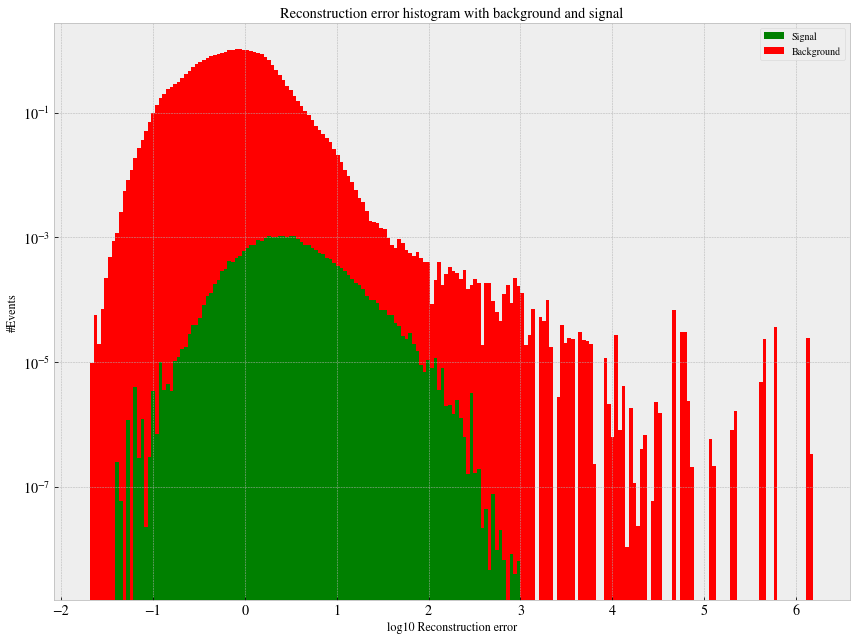

In [223]:
import plot_set
plt.rcParams["figure.figsize"] = (12,9)

fig, ax = plt.subplots()

n_bins= 200
colors = ["green", "red"]
labels= ["Signal", "Background"]
ax.hist(histo_data, n_bins, density=True, stacked=True, histtype='bar', color=colors, label=labels, weights=(s_test_weights, b_val_weights))
ax.legend(prop={'size': 10})
ax.set_title('Reconstruction error histogram with background and signal')
ax.set_xlabel('log10 Reconstruction error')
ax.set_ylabel('#Events')
ax.set_yscale('log')

fig.tight_layout()
plt.savefig("b_s_recon.pdf")
plt.show()

Here we plot the ROC curves for the model

In [235]:
# ROC
Y_b = np.zeros(X_b_val.shape[0]).reshape(X_b_val.shape[0],1);
Y_s = np.ones(X_s_test.shape[0]).reshape(X_s_test.shape[0],1);
Y_ROC = np.concatenate((Y_s, Y_b),0);

sample_weight = np.concatenate((s_test_weights, b_val_weights),0)

In [ ]:
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

rec_errors_ROC = np.concatenate((recon_err_sig,recon_err_back),0)



fpr, tpr, thresholds = roc_curve(Y_ROC, rec_errors_ROC, sample_weight = sample_weight, pos_label=1)
ae_auc = roc_auc_score(Y_ROC, rec_errors_ROC)
figRocAE, axRocAE = plt.subplots()
figRocAE.set_size_inches(12,12)
axRocAE.plot(fpr, tpr, label='ROC curve')
axRocAE.plot([0, 1], [0, 1], 'k--')
axRocAE.set_xlim([0.0, 1.0])
axRocAE.set_ylim([0.0, 1.05])
axRocAE.set_xlabel('False Anomaly Rate')
axRocAE.set_ylabel('True Anomaly Rate')
axRocAE.text(0.4,0.2,"AUC = %.4f" % ae_auc,fontsize=15)
axRocAE.set_title("Autoencoder ROC")

fig.tight_layout()
plt.savefig("b_s_roc_curve.pdf")
plt.show()